In [14]:
!pip install kmapper

  Using cached kmapper-2.1.0-py3-none-any.whl.metadata (4.9 kB)
Using cached kmapper-2.1.0-py3-none-any.whl (126 kB)


In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_distances
import kmapper as km
import sklearn
import webbrowser
from collections import Counter, defaultdict

Este notebook se va a basar en los jugadores del 2022, además de usar todas la mayoria de sus propiedades numericas

In [16]:
df=pd.read_csv('players_22.csv')

C:\Users\ce200\AppData\Local\Temp\ipykernel_1852\239572681.py:1: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('players_22.csv')


In [ ]:
df_char = df.loc[:,['age', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
                    'defending', 'defending_marking_awareness', 'defending_sliding_tackle', 'defending_standing_tackle',
                    'dribbling', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_positioning', 'goalkeeping_reflexes',
 'height_cm', 'mentality_aggression', 'mentality_composure', 'mentality_positioning',
 'mentality_vision', 'movement_acceleration', 'movement_agility', 'movement_balance',
 'movement_reactions',
 'movement_sprint_speed',
 'overall',
 'pace',
 'passing',
 'physic',
 'potential',
 'power_jumping',
 'power_long_shots',
 'power_shot_power',
 'power_stamina',
 'power_strength',
 'shooting',
 'skill_ball_control',
 'skill_curve',
 'skill_dribbling',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_moves']]

In [18]:
df_char.dropna(inplace=True)


Normalizamos los datos

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = df_char.copy()

num_cols = df_char.select_dtypes(include=["number"]).columns
df_scaled[num_cols] = scaler.fit_transform(df_char[num_cols])
df_scaled

,age,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,defending,defending_marking_awareness,defending_sliding_tackle,defending_standing_tackle,...,power_shot_power,power_stamina,power_strength,shooting,skill_ball_control,skill_curve,skill_dribbling,skill_fk_accuracy,skill_long_passing,skill_moves
0,1.925480,2.276439,2.754785,1.167674,3.028258,2.865871,-1.093541,-1.768508,-1.412150,-0.938529,...,2.033039,0.418890,0.263031,2.822155,3.420195,2.822236,2.947110,3.277251,2.890589,2.320176
1,1.493386,1.247304,2.754785,2.898000,2.383309,2.934695,-0.475848,-0.904885,-1.684452,-0.559267,...,2.336356,0.774344,1.601821,2.822155,2.581608,1.873257,2.022088,2.665410,1.134894,2.320176
2,2.357575,2.423458,2.754785,2.898000,1.845852,2.728222,-1.093541,-1.538209,-1.412150,-1.101070,...,2.639672,0.863207,0.893050,2.964492,2.581608,2.008825,2.274367,2.597428,1.720126,3.888939
3,0.845245,2.276439,2.016031,0.562060,2.490801,2.728222,-0.908233,-0.904885,-1.139849,-1.101070,...,1.578065,1.218661,-0.997006,2.181641,3.315372,2.483315,2.863017,2.801375,2.054544,3.888939
4,1.061292,2.938025,1.954468,-0.130070,3.350732,2.452924,0.759538,0.995086,0.167198,0.686880,...,2.412185,1.929569,0.656793,2.395146,2.896078,2.279962,2.274367,2.529446,3.057798,2.320176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,-0.667085,-0.590436,-1.123674,-0.735684,-1.378890,-1.125951,-0.599386,-0.732160,-0.105104,-0.505086,...,-1.000121,-1.447243,-1.548273,-1.234434,-1.506505,-1.244817,-1.341627,-0.529759,-0.704405,-0.817348
19235,-1.315226,-0.002359,-1.062111,-0.908717,-1.271398,-0.988302,-0.661156,-0.789735,-0.159564,-0.450906,...,-0.772634,-0.380881,-1.469520,-0.949761,-2.240269,0.110867,-1.677999,-1.005635,-0.537196,-0.817348
19236,-0.883132,-1.105003,-1.123674,-1.168266,-1.486381,-0.644179,-0.661156,-0.732160,-0.105104,-0.450906,...,-0.696805,-1.002925,-1.233263,-1.092098,-1.506505,-0.973681,-1.173441,-0.597741,-0.620800,-0.817348
19237,-1.315226,-1.840099,-0.077106,-1.427815,-2.668786,-0.850653,-2.267157,-2.344257,-2.120134,-2.076315,...,-0.848463,-1.536106,-2.020787,-0.451584,-1.925798,-1.041465,-1.593906,-0.801688,-1.958472,-0.817348


Ahora calculamos las distancias entre jugadores usando cosine distance, y luego generamos un filtro de densidad, que ayuda a encontrar regiones densas (jugadores similares entre sí).

In [ ]:
mapper = km.KeplerMapper(verbose=1)

# Distancias y filtro densidad
epsilon = 1e-5  # Evita divisiones por cero
dxy = cosine_distances(df_scaled)
c_eps = 1 / np.sum(np.exp(-dxy / epsilon))
filtro_densidad = c_eps * np.sum(np.exp(-dxy / epsilon), axis=1)


Sacamos el Grafo con mapper

In [56]:
# Grafo topológico
graph = mapper.map(
    filtro_densidad,
    df_scaled,
    clusterer=sklearn.cluster.DBSCAN(metric="cosine"),
    cover=km.Cover(n_cubes=100, perc_overlap=0.05),
)

Mapping on data shaped (17107, 42) using lens shaped (17107,)

Creating 100 hypercubes.

Created 104 edges and 118 nodes in 0:00:00.748334.


In [57]:
# Etiquetas para el mapper
df['player-position'] = df['short_name'] + " - " + df['player_positions']

# Visualización
mapper.visualize(
    graph,
    path_html="jugadoresDensidad_tda.html",
    title="Datos Jugadores - Filtro Densidad",
    colorscale=None,
    nbins=15,
    node_color_function=["mean", "std", "median", "max"],
    custom_tooltips=df['player-position'].values,
)

webbrowser.open("jugadoresDensidad_tda.html")

Wrote visualization to: jugadoresDensidad_tda.html


True

Visualizamos el grafo, aca una foto de como quedo

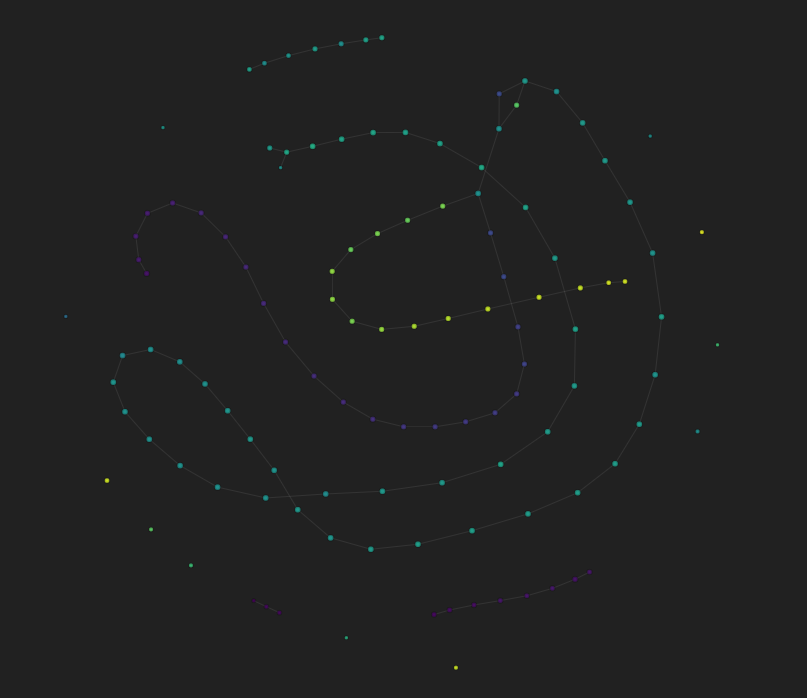

Mostramos el grafo

In [49]:
# ======== Asignar nodos a jugadores ========
node_to_player_indices = {}
for node_id, member_indices in graph['nodes'].items():
    node_to_player_indices[node_id] = member_indices

df['node_id'] = -1
for node_id, indices in node_to_player_indices.items():
    df.loc[indices, 'node_id'] = node_id

# ======== Identificar nodos densos ========
node_counts = Counter(df['node_id'])
top_nodes = node_counts.most_common(10)
elite_node_ids = [node_id for node_id, _ in top_nodes[:3]]

print("Top nodos más densos:")
for node_id, count in top_nodes[:3]:
    print(f"Nodo {node_id}: {count} jugadores")


Top nodos más densos:
Nodo -1: 2535 jugadores
Nodo cube44_cluster0: 335 jugadores
Nodo cube43_cluster0: 327 jugadores


C:\Users\ce200\AppData\Local\Temp\ipykernel_1852\4045199303.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'cube5_cluster0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[indices, 'node_id'] = node_id


Agarramos los nodos mas densos

In [50]:
# ======== Filtrar mejores jugadores de nodos top ========
elite_players = df[df['node_id'].isin(elite_node_ids)].copy()
elite_players = elite_players.sort_values(by=['overall', 'potential'], ascending=False)


Identificamos a los mejores jugadores con base a los nodos mas densos

In [ ]:
top_11 = defaultdict(list)

for _, row in elite_players.iterrows():
    positions = row['player_positions'].split(", ")
    for pos in positions:
        if pos.startswith("GK") and len(top_11['GK']) < 1:
            top_11['GK'].append(row)
        elif pos.startswith("CB") or pos in ["LB", "RB", "LWB", "RWB"]:
            if len(top_11['DEF']) < 4:
                top_11['DEF'].append(row)
        elif pos in ["CM", "CDM", "CAM", "LM", "RM"]:
            if len(top_11['MID']) < 3:
                top_11['MID'].append(row)
        elif pos in ["ST", "CF", "LW", "RW"]:
            if len(top_11['FWD']) < 3:
                top_11['FWD'].append(row)
        if sum(len(v) for v in top_11.values()) == 11:
            break
    if sum(len(v) for v in top_11.values()) == 11:
        break

Imprimimos a mi top

In [ ]:
print("\nTop 11 Equipo Ideal:")
for role, players in top_11.items():
    print(f"\n{role}:")
    for p in players:
        print(f"{p['short_name']} - {p['player_positions']} - Overall: {p['overall']} - Potential: {p['potential']}")


⭐ Top 11 Equipo Ideal:

MID:
T. Kroos - CM - Overall: 88 - Potential: 88
Parejo - CM - Overall: 86 - Potential: 86
K. Trippier - RB, RWB, RM - Overall: 84 - Potential: 84

DEF:
S. de Vrij - CB - Overall: 85 - Potential: 85
K. Trippier - RB, RWB, RM - Overall: 84 - Potential: 84
K. Trippier - RB, RWB, RM - Overall: 84 - Potential: 84
J. Corona - RM, RB, RW - Overall: 82 - Potential: 82

GK:
L. Hrádecký - GK - Overall: 83 - Potential: 83

FWD:
Morata - ST - Overall: 83 - Potential: 83
W. Weghorst - ST - Overall: 83 - Potential: 83
J. Corona - RM, RB, RW - Overall: 82 - Potential: 82


Ahi mero queda el equipo ideal para irle a ganar a tu cuate en el FIFA 2022, si quieren para el nuevo FIFA contactenme